## Hybrid Attempt (v2)

>>> INIZIO PIPELINE IBRIDA (CON INFLAZIONE PCA) ANALISI GOOGLE TRENDS E PCA <<<

--- Inizio Caricamento Dati ---
Dati caricati con successo per 'Termini_Diretti' da 'Gruppo1(4).csv'
Dati caricati con successo per 'Alimentari' da 'Gruppo2(4).csv'
Dati caricati con successo per 'Energia' da 'Gruppo3(4).csv'
Dati caricati con successo per 'Abitazione' da 'Gruppo4(4).csv'
Dati caricati con successo per 'Trasporti' da 'Gruppo5(4).csv'
Dati caricati con successo per 'Politiche_Economiche' da 'Gruppo6(4).csv'
Dati caricati con successo per 'Aspettative_Consumatori' da 'Gruppo7(4).csv'
Dati caricati con successo per 'Sanita' da 'Gruppo8(4).csv'
Dati caricati con successo per 'Ricreazione' da 'Gruppo9(4).csv'
--- Fine Caricamento Dati ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DF combinato 252 righe x 45 colonne.
--- Fine Combinazione Dati 

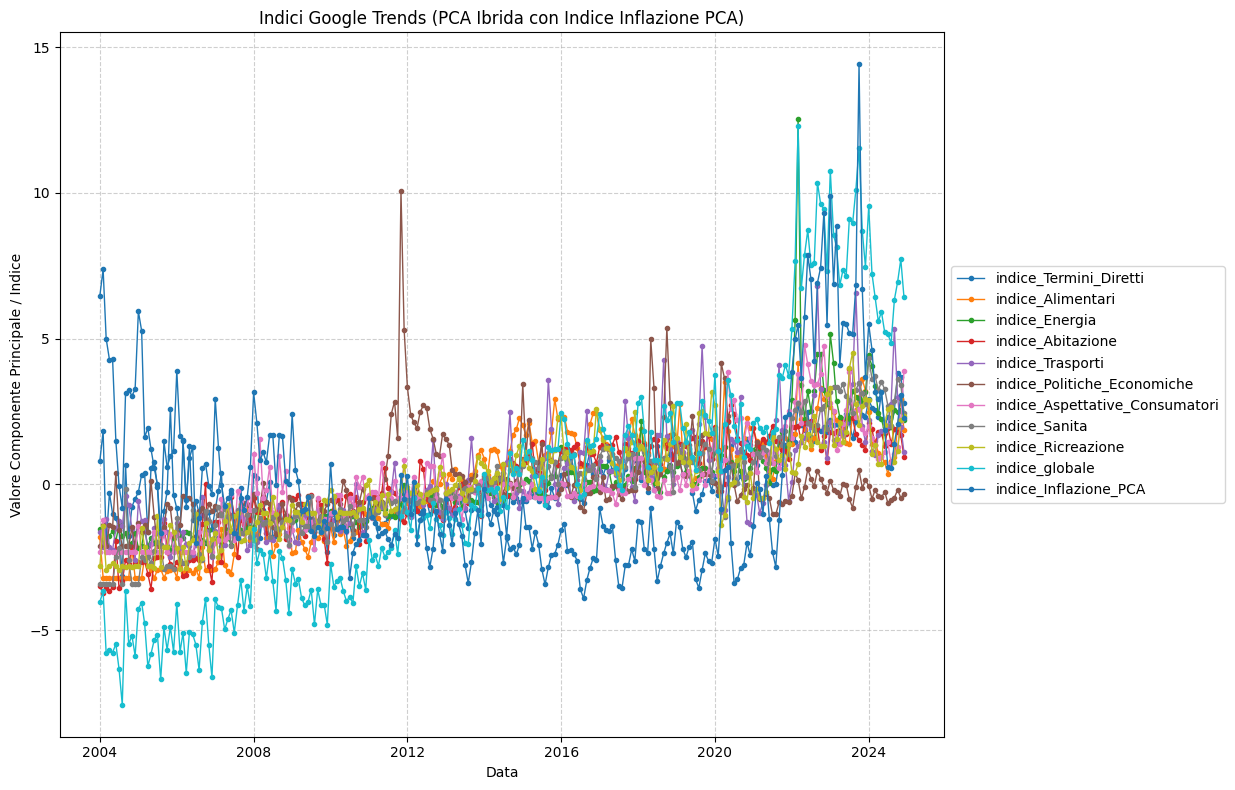

Info: Indici salvati in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_ibrido_v2.csv'
--- Fine Visualizzazione e Salvataggio Indici ---


>>> PIPELINE IBRIDA (CON INFLAZIONE PCA) COMPLETATA <<<


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4"
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_ibrido_v2.csv'

NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione"
}
# Parola chiave per identificare le colonne relative all'inflazione
INFLATION_KEYWORD = "inflazione" # La query è definita "inflazione: (italia)" nei csv

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    dati_caricati_per_gruppo = {}
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0)
            df.columns = [str(col).strip().lower() for col in df.columns]
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None:
                raise ValueError(f"Nessuna colonna data standard trovata in {nome_file_csv}")
            if colonna_data != 'mese':
                print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}.")
            df.set_index(colonna_data, inplace=True)
            try:
                df.index = pd.to_datetime(df.index)
            except Exception as e_date:
                try:
                    df.index = pd.to_datetime(df.index, format="%Y-%m")
                except Exception:
                    raise e_date
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
            print(f"Dati caricati con successo per '{nome_gruppo_logico}' da '{nome_file_csv}.csv'")
        except Exception as e:
            print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print("--- Fine Caricamento Dati ---\n")
    return dati_caricati_per_gruppo

# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input: return None, None
    date_inizio_valide, date_fine_valide = [], []
    for gruppo, df in dati_dict_input.items():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min())
            date_fine_valide.append(df.index.max())
    if not date_inizio_valide: return None, None
    inizio_comune_calc, fine_comune_calc = max(date_inizio_valide), min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc: return None, None
    print(f"Info (Periodo Comune): Da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc

# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input: return None
    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS')
    df_combinato_finale = pd.DataFrame(index=idx_comune)
    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex): continue
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]
        if df_periodo_gruppo.empty: continue
        for col_originale_nome in df_periodo_gruppo.columns:
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"
            serie_reindicizzata = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
            df_combinato_finale[nome_colonna_con_prefisso] = serie_reindicizzata
    print(f"Info (Combinazione): DF combinato {df_combinato_finale.shape[0]} righe x {df_combinato_finale.shape[1]} colonne.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale

# --- 4. PULIZIA VALORI SPECIFICI DI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None: return None
    df_pulito = df_input.copy()
    for col in df_pulito.columns:
        col_as_str = df_pulito[col].astype(str)
        if col_as_str.str.contains(r'< ?1').any():
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')
    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito

# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0): # Semplificato per brevità
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None: return None
    df_gestito = df_input.copy()
    if not df_gestito.isnull().values.any():
        print("Info (Gestione NaN): Nessun NaN trovato."); return df_gestito
    if strategy == 'fillna':
        df_gestito = df_gestito.fillna(fill_value)
    elif strategy == 'interpolate': # Aggiunta interpolazione come opzione
        df_gestito = df_gestito.interpolate(method='linear', axis=0)
        if df_gestito.isnull().values.any(): # Fallback se rimangono NaN (es. inizio/fine serie)
            df_gestito = df_gestito.fillna(fill_value)
    # Altre strategie omesse per brevità
    print("Info (Gestione NaN): NaN gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito

# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None: return None
    df_std = df_input.copy()
    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]): continue
        media, std_dev = df_std[col].mean(), df_std[col].std()
        df_std[col] = (df_std[col] - media) / std_dev if std_dev != 0 else 0
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std

# --- 7. CREAZIONE INDICE INFLAZIONE TRAMITE PCA E SEPARAZIONE TERMINI (MODIFICATA) ---
def crea_indice_inflazione_pca_e_separa_termini(df_std_input, inflation_keyword_in_colname):
    """
    Estrae tutte le colonne contenenti la 'inflation_keyword', applica PCA per creare un indice inflazione aggregato,
    e restituisce questo indice e un DataFrame senza queste colonne "inflazione".
    """
    print(f"--- Inizio Creazione Indice Inflazione PCA (keyword: '{inflation_keyword_in_colname}') ---")
    if df_std_input is None or df_std_input.empty:
        print("Errore (Indice Inflazione PCA): DataFrame input è None o vuoto.")
        return pd.Series(dtype=float), df_std_input # Restituisce serie vuota e df originale

    colonne_inflazione = [col for col in df_std_input.columns if inflation_keyword_in_colname.lower() in col.lower()]
    
    indice_inflazione_pca_series = pd.Series(index=df_std_input.index, dtype=float) # Inizializza con NaN
    df_senza_termini_inflazione = df_std_input.copy()

    if not colonne_inflazione:
        print(f"Attenzione (Indice Inflazione PCA): Nessun termine contenente '{inflation_keyword_in_colname}' trovato.")
    else:
        df_solo_termini_inflazione = df_std_input[colonne_inflazione].copy()
        # Rimuovi colonne con varianza nulla prima della PCA
        df_solo_termini_inflazione_validi = df_solo_termini_inflazione.loc[:, df_solo_termini_inflazione.var() > 1e-9]

        if df_solo_termini_inflazione_validi.empty:
            print(f"Attenzione (Indice Inflazione PCA): Nessun termine '{inflation_keyword_in_colname}' con varianza sufficiente.")
        elif df_solo_termini_inflazione_validi.shape[1] == 1: # Se solo una colonna inflazione valida
            print(f"Info (Indice Inflazione PCA): Usata direttamente la singola colonna valida: {df_solo_termini_inflazione_validi.columns[0]}")
            indice_inflazione_pca_series = df_solo_termini_inflazione_validi.iloc[:, 0]
        else: # Almeno 2 colonne inflazione valide per PCA
            pca_infl = PCA(n_components=1)
            try:
                if df_solo_termini_inflazione_validi.isnull().values.any():
                     # Questo non dovrebbe succedere se gestisci_nan è stato chiamato prima
                    raise ValueError("NaN presenti nei dati per PCA dell'indice inflazione.")
                componente_infl = pca_infl.fit_transform(df_solo_termini_inflazione_validi)
                indice_inflazione_pca_series = pd.Series(componente_infl.flatten(), index=df_solo_termini_inflazione_validi.index)
                print(f"Info (Indice Inflazione PCA): Creato da {df_solo_termini_inflazione_validi.shape[1]} termini. Var. Spiegata: {pca_infl.explained_variance_ratio_[0]:.2%}")
                print("  Loadings sull'Indice Inflazione PCA:")
                for i, col_pca_nome in enumerate(df_solo_termini_inflazione_validi.columns):
                    print(f"    {col_pca_nome}: {pca_infl.components_[0][i]:.4f}")
            except Exception as e_pca_infl:
                print(f"ERRORE durante PCA per Indice Inflazione: {e_pca_infl}")
        
        # Rimuovi le colonne inflazione dal DataFrame principale
        df_senza_termini_inflazione = df_std_input.drop(columns=colonne_inflazione, errors='ignore')
        print(f"Info (Indice Inflazione PCA): Rimossi termini '{inflation_keyword_in_colname}'. Rimanenti {df_senza_termini_inflazione.shape[1]} colonne per PCA di gruppo.")
    
    print("--- Fine Creazione Indice Inflazione PCA ---\n")
    return indice_inflazione_pca_series, df_senza_termini_inflazione


# --- 8. CREAZIONE INDICI PCA PER GRUPPO (SENZA TERMINI INFLAZIONE) ---
def crea_indici_pca_per_gruppo_ibrido(df_input_senza_infl, nomi_gruppi_mappati):
    print("--- Inizio Creazione Indici PCA per Gruppo (Senza Termini Inflazione) ---")
    if df_input_senza_infl is None or df_input_senza_infl.empty:
        return pd.DataFrame(index=df_input_senza_infl.index if df_input_senza_infl is not None else None)
    indici_pca_df = pd.DataFrame(index=df_input_senza_infl.index)
    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        colonne_del_gruppo = [col for col in df_input_senza_infl.columns if col.startswith(f"{nome_gruppo_logico}_")]
        if not colonne_del_gruppo:
            indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan; continue
        dati_gruppo_pca_validi = df_input_senza_infl[colonne_del_gruppo].loc[:, df_input_senza_infl[colonne_del_gruppo].var() > 1e-9]
        if dati_gruppo_pca_validi.shape[1] >= 1:
            if dati_gruppo_pca_validi.shape[1] == 1:
                indici_pca_df[f'indice_{nome_gruppo_logico}'] = dati_gruppo_pca_validi.iloc[:, 0]
            else:
                pca = PCA(n_components=1)
                try:
                    if dati_gruppo_pca_validi.isnull().values.any(): raise ValueError("NaN in group PCA data.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)
                    indici_pca_df[f'indice_{nome_gruppo_logico}'] = componente.flatten()
                    print(f"\nGruppo '{nome_gruppo_logico}' (Senza Termini Infl.): Var: {pca.explained_variance_ratio_[0]:.2%} ({dati_gruppo_pca_validi.shape[1]} vars)")
                    # print("  Loadings:"); [print(f"    {n}: {l:.4f}") for n,l in zip(dati_gruppo_pca_validi.columns, pca.components_[0])] # Log Loadings Opzionale
                except Exception as e: print(f"ERRORE PCA grp '{nome_gruppo_logico}': {e}"); indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
        else: indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
    print("--- Fine Creazione Indici PCA per Gruppo ---\n")
    return indici_pca_df

# --- 9. CREAZIONE INDICE PCA GLOBALE (CON INDICE INFLAZIONE PCA) ---
def crea_indice_pca_globale_ibrido_v2(df_indici_gruppo_puri, serie_indice_inflazione_pca):
    print("--- Inizio Creazione Indice PCA Globale (Ibrido con Inflazione PCA) ---")
    if df_indici_gruppo_puri is None: return None # Gestione input nullo

    df_per_pca_globale = df_indici_gruppo_puri.copy()
    nome_col_infl_pca = 'indice_Inflazione_PCA' # Nome colonna per l'indice inflazione

    if serie_indice_inflazione_pca is not None and not serie_indice_inflazione_pca.isnull().all():
        df_per_pca_globale[nome_col_infl_pca] = serie_indice_inflazione_pca
    else: print(f"Attenzione: '{nome_col_infl_pca}' non valido o tutto NaN. Non incluso in PCA globale.")

    df_per_pca_globale_no_nan = df_per_pca_globale.dropna(axis=0, how='any')
    if df_per_pca_globale_no_nan.empty:
        print("Attenzione: Nessuna riga dopo rimozione NaN. Indice globale non creato.")
        df_indici_gruppo_puri['indice_globale'] = np.nan; return df_indici_gruppo_puri

    indici_validi = df_per_pca_globale_no_nan.loc[:, df_per_pca_globale_no_nan.var() > 1e-9]
    if indici_validi.shape[1] >= 1:
        if indici_validi.shape[1] == 1:
            indice_globale_serie = indici_validi.iloc[:,0].reindex(df_indici_gruppo_puri.index)
            df_indici_gruppo_puri['indice_globale'] = indice_globale_serie
        else:
            pca_glob = PCA(n_components=1)
            try:
                componente_globale = pca_glob.fit_transform(indici_validi)
                indice_globale_serie = pd.Series(componente_globale.flatten(), index=indici_validi.index)
                df_indici_gruppo_puri['indice_globale'] = indice_globale_serie
                print(f"\nIndice Globale (Ibrido con Inflazione PCA): Var: {pca_glob.explained_variance_ratio_[0]:.2%} ({indici_validi.shape[1]} indici)")
                print("  Loadings:"); [print(f"    {n}: {l:.4f}") for n,l in zip(indici_validi.columns, pca_glob.components_[0])]
            except Exception as e: print(f"ERRORE PCA globale: {e}"); df_indici_gruppo_puri['indice_globale'] = np.nan
    else: df_indici_gruppo_puri['indice_globale'] = np.nan
    
    # Assicura che la colonna indice inflazione PCA sia nel df finale per visualizzazione/salvataggio
    if nome_col_infl_pca not in df_indici_gruppo_puri.columns and serie_indice_inflazione_pca is not None :
         df_indici_gruppo_puri[nome_col_infl_pca] = serie_indice_inflazione_pca.reindex(df_indici_gruppo_puri.index)

    print("--- Fine Creazione Indice PCA Globale ---\n")
    return df_indici_gruppo_puri

# --- 10. VISUALIZZAZIONE E SALVATAGGIO ---
def visualizza_e_salva_indici(df_indici_finali, path_salvataggio_csv):
    print("--- Inizio Visualizzazione e Salvataggio Indici ---")
    if df_indici_finali is None or df_indici_finali.empty: return
    df_to_plot = df_indici_finali.select_dtypes(include=np.number)
    if not df_to_plot.empty:
        plt.figure(figsize=(15, 8))
        for col_nome in df_to_plot.columns:
            if not df_to_plot[col_nome].isnull().all():
                 plt.plot(df_to_plot.index, df_to_plot[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1)
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles: plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Indici Google Trends (PCA Ibrida con Indice Inflazione PCA)')
        plt.xlabel('Data'); plt.ylabel('Valore Componente Principale / Indice')
        plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()
    try:
        os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True)
        df_indici_finali.to_csv(path_salvataggio_csv, index=True)
        print(f"Info: Indici salvati in '{path_salvataggio_csv}'")
    except Exception as e: print(f"ERRORE salvataggio: {e}")
    print("--- Fine Visualizzazione e Salvataggio Indici ---\n")

# --- ESECUZIONE PIPELINE ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE IBRIDA (CON INFLAZIONE PCA) ANALISI GOOGLE TRENDS E PCA <<<\n")

    # 1. Caricamento
    dati_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    start_date, end_date = trova_periodo_comune(dati_caricati)

    # 3. Combinazione Dati
    df_combinato = combina_dati_su_periodo_comune(dati_caricati, start_date, end_date)

    # 4. Pulizia Valori GT ('<1')
    df_pulito_gt = pulisci_valori_gt(df_combinato)

    # 5. Gestione NaN (Scegliere la strategia più adatta)
    df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0)
    # Alternativa: df_senza_nan = gestisci_nan(df_pulito_gt, strategy='interpolate')


    # 6. Standardizzazione
    df_standardizzato = standardizza_serie_temporali(df_senza_nan)

    # 7. Creazione Indice Inflazione tramite PCA e Separazione Termini
    serie_inflazione_pca, df_std_senza_termini_infl = crea_indice_inflazione_pca_e_separa_termini(
        df_standardizzato, 
        INFLATION_KEYWORD
    )

    # 8. PCA per Gruppo (sui termini rimanenti, senza quelli usati per serie_inflazione_pca)
    df_indici_gruppo_senza_termini_infl = crea_indici_pca_per_gruppo_ibrido(
        df_std_senza_termini_infl,
        NOMI_GRUPPI_DICT
    )

    # 9. PCA Globale (Ibrida: combina indici di gruppo purificati + indice inflazione PCA)
    df_indici_finali = crea_indice_pca_globale_ibrido_v2(
        df_indici_gruppo_senza_termini_infl,
        serie_inflazione_pca # Passa la serie creata con PCA
    )

    # 10. Visualizzazione e Salvataggio
    visualizza_e_salva_indici(df_indici_finali, PATH_SALVATAGGIO_INDICI)

    print("\n>>> PIPELINE IBRIDA (CON INFLAZIONE PCA) COMPLETATA <<<")
